<a href="https://colab.research.google.com/github/seymadogru/BasicDataTypes/blob/master/warehouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import gym
from gym import spaces
import numpy as np
import time
from IPython.display import clear_output # Colab'de ekranı temizlemek için

class WarehouseStockingEnv(gym.Env):
    def __init__(self, grid_size=6):
        super(WarehouseStockingEnv, self).__init__()

        self.grid_size = grid_size
        self.map = np.zeros((grid_size, grid_size), dtype=int)
        self._generate_map()

        # 0: Yukarı, 1: Aşağı, 2: Sola, 3: Sağa, 4: Yerleştir
        self.action_space = spaces.Discrete(5)

        # Gözlem: [Robot X, Robot Y, Elindeki Ürün Tipi]
        low = np.array([0, 0, 0])
        high = np.array([grid_size, grid_size, 3])
        self.observation_space = spaces.Box(low, high, dtype=np.int32)

        self.agent_pos = [0, 0]
        self.stock_list = []
        self.current_item = 0
        self.max_steps = 100
        self.current_step = 0

    def _generate_map(self):
        self.map.fill(0)
        # Engeller
        self.map[2, 2] = 1; self.map[2, 3] = 1; self.map[2, 4] = 1; self.map[4, 1] = 1
        # Raflar
        self.shelves_type_2 = [[0, 5], [1, 5]]
        self.shelves_type_3 = [[4, 4], [5, 4]]

        for pos in self.shelves_type_2: self.map[pos[0], pos[1]] = 2
        for pos in self.shelves_type_3: self.map[pos[0], pos[1]] = 3

    def reset(self):
        self.agent_pos = [0, 0]
        self.current_step = 0
        self.stock_list = list(np.random.choice([2, 3], 5)) # 5 ürünlük liste
        self.current_item = self.stock_list.pop(0)
        return np.array([self.agent_pos[0], self.agent_pos[1], self.current_item])

    def step(self, action):
        self.current_step += 1
        reward = -1
        done = False

        prev_pos = self.agent_pos.copy()

        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1: self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 2: self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3: self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)

        # Duvar Kontrolü
        if self.map[self.agent_pos[0], self.agent_pos[1]] == 1:
            reward = -10
            self.agent_pos = prev_pos

        # Yerleştirme Mantığı
        if action == 4:
            current_cell_type = self.map[self.agent_pos[0], self.agent_pos[1]]
            if current_cell_type == self.current_item:
                reward = 50
                if len(self.stock_list) > 0:
                    self.current_item = self.stock_list.pop(0)
                    # Robotu başa alma (isteğe bağlı, şimdilik olduğu yerde kalsın)
                else:
                    reward += 100
                    done = True
            else:
                reward = -10

        if self.current_step >= self.max_steps:
            done = True

        return np.array([self.agent_pos[0], self.agent_pos[1], self.current_item]), reward, done, {}

    def render(self):
        # Colab için görselleştirme
        print(f"Adım: {self.current_step} | Elindeki Ürün: {self.current_item}")
        print("-" * 15)
        for x in range(self.grid_size):
            row = ""
            for y in range(self.grid_size):
                if x == self.agent_pos[0] and y == self.agent_pos[1]:
                    row += "🤖" # Robot
                elif self.map[x, y] == 1:
                    row += "🧱" # Duvar
                elif self.map[x, y] == 2:
                    row += "🅰️" # Raf A
                elif self.map[x, y] == 3:
                    row += "🅱️" # Raf B
                else:
                    row += "⬜" # Yol
            print(row)

**Train**

Eğitim ve Veri Toplama Başlıyor...
Eğitim Bitti! Grafikler çiziliyor...


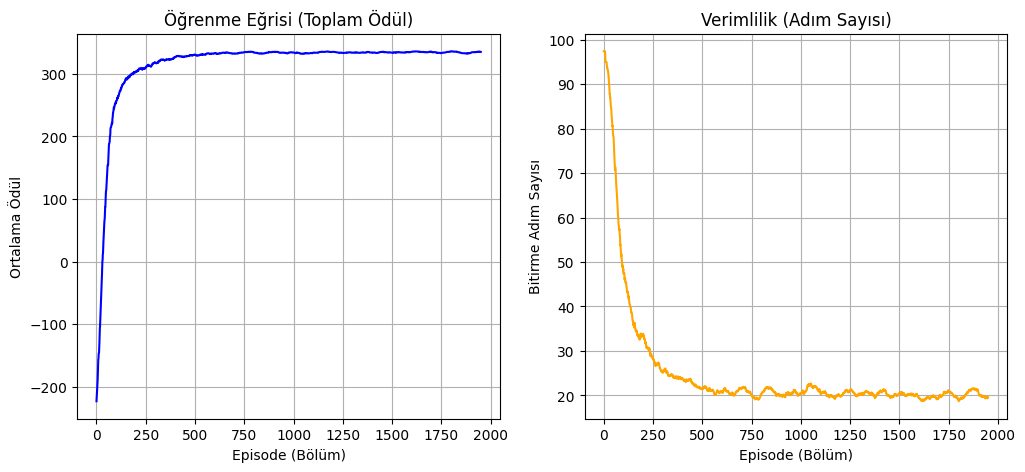

In [7]:
import matplotlib.pyplot as plt

# --- Ayarlar ---
env = WarehouseStockingEnv(grid_size=6)
q_table = {}

alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01

def get_state_key(obs):
    return tuple(obs)

# Veri toplamak için listeler
all_rewards = []
all_steps = []

print("Eğitim ve Veri Toplama Başlıyor...")

episodes = 2000 # 2000 bölüm
for episode in range(episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False
    total_reward = 0
    steps = 0

    while not done:
        # Action Seç
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
            action = np.argmax(q_table[state])

        # Uygula
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state_key(next_obs)

        # Q-Table Güncelle
        if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
        if next_state not in q_table: q_table[next_state] = np.zeros(env.action_space.n)

        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state][action] = new_value

        state = next_state
        total_reward += reward
        steps += 1

    # Verileri kaydet
    all_rewards.append(total_reward)
    all_steps.append(steps)

    # Epsilon azalt
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

print("Eğitim Bitti! Grafikler çiziliyor...")

# --- GRAFİK ÇİZME BÖLÜMÜ ---

# Veriyi yumuşatmak (Moving Average) için fonksiyon
# Ham veri çok zikzaklı olur, trendi görmek için ortalama alırız.
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 5))

# 1. Grafik: Ödül Değişimi
plt.subplot(1, 2, 1)
plt.plot(moving_average(all_rewards), color='blue')
plt.title("Öğrenme Eğrisi (Toplam Ödül)")
plt.xlabel("Episode (Bölüm)")
plt.ylabel("Ortalama Ödül")
plt.grid(True)

# 2. Grafik: Adım Sayısı Değişimi
plt.subplot(1, 2, 2)
plt.plot(moving_average(all_steps), color='orange')
plt.title("Verimlilik (Adım Sayısı)")
plt.xlabel("Episode (Bölüm)")
plt.ylabel("Bitirme Adım Sayısı")
plt.grid(True)

plt.show()

**Gözlem**

In [8]:
# Test Aşaması
obs = env.reset()
state = get_state_key(obs)
done = False
total_reward = 0

print("Robot Göreve Başlıyor...")
time.sleep(1)

while not done:
    clear_output(wait=True) # Önceki kareyi sil
    env.render() # Yeni kareyi çiz

    # Sadece bildiğini oku (Epsilon yok)
    if state in q_table:
        action = np.argmax(q_table[state])
    else:
        action = env.action_space.sample() # Bilmediği bir yerdeyse rastgele

    obs, reward, done, _ = env.step(action)
    state = get_state_key(obs)
    total_reward += reward

    time.sleep(0.3) # Hızı ayarla

print(f"\nOyun Bitti! Toplam Puan: {total_reward}")

Adım: 20 | Elindeki Ürün: 3
---------------
⬜⬜⬜⬜⬜🅰️
⬜⬜⬜⬜⬜🅰️
⬜⬜🧱🧱🧱⬜
⬜⬜⬜⬜⬜⬜
⬜🧱⬜⬜🤖⬜
⬜⬜⬜⬜🅱️⬜

Oyun Bitti! Toplam Puan: 334
